In [2]:
import sys

import pandas as pd
import datetime
import time
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import os
import pytz
# from fpdf import FPDF
#import multiprocessing
import timeit
from datetime import datetime
from datetime import timedelta


devices = pd.read_csv('/home/emilyp/Dropbox/PDE/device_id_for_url.txt')

In [162]:
### Definitions of functions to download and manipulate energy data
def download_nrg(start_date, end_date,devid):

    r = requests.post("https://m3.meazon.com/api/auth/login",
                      json={'username': 'meazon@thingsboard.org', 'password': 'meazon'}).json()

    # acc_token is the token to be used in the next request
    acc_token = 'Bearer' + ' ' + r['token']

    start_time = str(start_date)
    end_time = str(end_date)

    r2 = requests.get(
        url="https://m3.meazon.com/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=cnrgA,cnrgB,cnrgC&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

    if r2:
        dfA = pd.DataFrame(r2['cnrgA'])
        dfA.set_index('ts', inplace=True)
        dfA.columns = ['cnrgA']

        dfB = pd.DataFrame(r2['cnrgB'])
        dfB.set_index('ts', inplace=True)
        dfB.columns = ['cnrgB']

        dfC = pd.DataFrame(r2['cnrgC'])
        dfC.set_index('ts', inplace=True)
        dfC.columns = ['cnrgC']


        df = pd.concat([dfA, dfB, dfC])

        df.reset_index(drop=False, inplace=True)
        df['ts'] = pd.to_datetime(df['ts'], unit='ms')
        df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens').dt.tz_localize(None)

        df = df.sort_values(by=['ts'])
        df.reset_index(drop=True, inplace=True)
        df.columns = ['Timestamp', 'cnrgA', 'cnrgB', 'cnrgC']
    else:
        df = pd.DataFrame([])
        print('Empty json!')

    return df


def fill_missing_values(df):
    # merge rows with same datetime to exclude nans
    df = df.groupby(df.index).max()
    df.sort_index(inplace = True)


    # create datetime series to import missing dates and reindex
    start_date = df.index[0]
    end_date = df.index[-1]
    idx = pd.date_range(start_date,end_date, freq = '1T')
    df = df.reindex(idx)
        
    return df


def create_nrg_table(df):
    df['cnrgA'] = df['cnrgA'].astype(float)
    df['cnrgB'] = df['cnrgB'].astype(float)
    df['cnrgC'] = df['cnrgC'].astype(float)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y/%m/%d %H:%M:%S.%f')
    df = df.sort_values(by="Timestamp")
    
    df['Timestamp'] = df['Timestamp'].astype('datetime64[s]')
    df = df.set_index('Timestamp', drop=True)
    df.index = df.index.map(lambda x: x.replace(second=0))
    
    df = fill_missing_values(df)
    df['Timestamp'] = df.index
    df['total'] = df['cnrgA'] + df['cnrgB'] + df['cnrgC']
    
    return df

def conv_to_consumption(df):
#     convert cumulative energy to consumed energy

    df['diffA']=np.nan
    df['diffB']=np.nan
    df['diffC']=np.nan
    df.diffA[((df.cnrgA.isna() == False) & (df.cnrgA.shift().isna() == False))] = df.cnrgA-df.cnrgA.shift()
    df.diffB[(df.cnrgB.isna() == False) & (df.cnrgB.shift().isna() == False)] = df.cnrgB-df.cnrgB.shift()
    df.diffC[(df.cnrgC.isna() == False) & (df.cnrgC.shift().isna() == False)] = df.cnrgC-df.cnrgC.shift()
    
    df.diffA.iloc[0]=0
    df.diffB.iloc[0]=0
    df.diffC.iloc[0]=0
    
    df['total'] = np.nan
    df.total[(df.diffA.isna() == False) & (df.diffB.isna() == False) & (df.diffC.isna() == False)] = df.diffA + df.diffB + df.diffC

    return df
    


def find_nans(cnrg,energy):

    # store starting points of NaNs
    df_start = energy[(energy[cnrg].isnull()) & (energy[cnrg].shift().isnull()==False)]
    df_start['endpoint'] = energy.index[(energy[cnrg].isnull()) & (energy[cnrg].shift(-1).isnull()==False)]
    df_start = df_start.drop(['cnrgA','cnrgB','cnrgC','total'],axis = 1)

    df_start['previous_dt'] = df_start.index -timedelta(minutes=1)
    df_start['next_dt'] = df_start.endpoint + timedelta(minutes=1)
    df_start['previous_week_start'] = df_start.previous_dt -timedelta(days=7)
    df_start['previous_week_end'] = df_start.next_dt - timedelta(days=7)

    df_start['next_week_start'] = df_start.previous_dt + timedelta(days=7)
    df_start['next_week_end'] = df_start.next_dt + timedelta(days=7)
    
    return df_start




def backfill(row, cnrg,energy):
    tmp = pd.DataFrame(energy.loc[row.previous_week_start:row.previous_week_end])
    if tmp.shape[0] == 0:
        tmp = pd.DataFrame(energy.loc[row.previous_week_start+timedelta(days=7):row.previous_week_end+timedelta(days=7)])
    if tmp.shape[0]>0:
        
        start1 = tmp[cnrg].iloc[0]  # starting point of previous week
        start2 = energy[cnrg].loc[row.previous_dt]  # starting point of current week

        diff1 = tmp[cnrg].iloc[-1] - start1  # diff of previous week
        diff2 = energy[cnrg].loc[row.next_dt] - start2  # diff of current week
        
        
        for i in range(1, tmp.shape[0] - 1) :
            if ((tmp[cnrg].iloc[i] - start1) != diff1 and (diff1!=0)):
                perc = (tmp[cnrg].iloc[i] - start1) / diff1
                energy[cnrg].loc[row.previous_dt + timedelta(minutes=i)] = perc * diff2 + start2
                
            else:
                perc = 0
                energy[cnrg].loc[row.previous_dt + timedelta(minutes=i)] = energy[cnrg].loc[row.previous_dt + timedelta(minutes=i-1)]
            
            

def forwardfill(row, cnrg,energy):
    
    tmp = energy.loc[row.next_week_start:row.next_week_end]
    if tmp.shape[0] > 0:
        k=1
        while ((tmp[cnrg].iloc[0]+tmp[cnrg].iloc[-1]== tmp[cnrg].sum()) & (row.next_week_start - timedelta(days=k)>=energy.Timestamp.iloc[0])): # if  all intermediate values are nan
            tmp = energy.loc[row.next_week_start - timedelta(days=k):row.next_week_end - timedelta(days=k)]
            k=k+1

        if tmp.shape[0]>0 :   
            start1 = tmp[cnrg].iloc[0]  # starting point of next week
            diff1 = tmp[cnrg].iloc[-1] - start1  # diff of next week

            start2 = energy[cnrg].loc[row.previous_dt]  # starting point of current week
            diff2 = energy[cnrg].loc[row.next_dt] - start2  # diff of current week


            for i in range(1, tmp.shape[0] - 1):

                if ((tmp[cnrg].iloc[i] - start1) != diff1 and (diff1!=0)):
                    perc = (tmp[cnrg].iloc[i] - start1) / diff1
                    energy[cnrg].loc[row.previous_dt + timedelta(minutes=i)] = perc * diff2 + start2

                else:
                    perc = 0
                    energy[cnrg].loc[row.previous_dt + timedelta(minutes=i)] = energy[cnrg].loc[row.previous_dt + timedelta(minutes=i-1)]
                
        else:
            energy[cnrg] = energy[cnrg].interpolate()
            

    else:
        k=1
        while ((tmp.shape[0] == 0) & ((row.next_dt + timedelta(hours=24*k))<=energy.Timestamp.iloc[-1])):
            tmp = energy.loc[row.previous_dt + timedelta(hours=24*k):row.next_dt + timedelta(hours=24*k)]
            
            k=k+1
         
        if tmp.shape[0]>0:
            start1 = tmp[cnrg].iloc[0]  # starting point of next week
            diff1 = tmp[cnrg].iloc[-1] - start1  # diff of next week


            start2 = energy[cnrg].loc[row.previous_dt]  # starting point of current week
            diff2 = energy[cnrg].loc[row.next_dt] - start2  # diff of current week


            for i in range(1, tmp.shape[0] - 1):

                if ((tmp[cnrg].iloc[i] - start1) != diff1 and (diff1!=0)):
                    perc = (tmp[cnrg].iloc[i] - start1) / diff1
                    energy[cnrg].loc[row.previous_dt + timedelta(minutes=i)] = perc * diff2 + start2
                else:
                    perc = 0
                    energy[cnrg].loc[row.previous_dt + timedelta(minutes=i)] = energy[cnrg].loc[row.previous_dt + timedelta(minutes=i-1)]
        else:
            energy[cnrg] = energy[cnrg].interpolate()
        

def fill_nans(nrg,energy):
    for cnrg in nrg:

        df_start = find_nans(cnrg,energy)

        df_start.apply((lambda x: backfill(x, cnrg,energy)), axis=1)
        print('backfill ended')

        while energy[cnrg].isna().sum() > 0:
            
            df_start = find_nans(cnrg,energy)
            df_start.apply((lambda x: forwardfill(x, cnrg,energy)), axis=1)
        print('forward fill ended')
            
def fill_dropped_nrg(df,nrg):
    for cnrg in nrg:
        dfnew = df[np.isfinite(df[cnrg])].copy()
        dropped = dfnew[dfnew[cnrg]<dfnew[cnrg].shift()]
        
        if dropped.empty==False:
            # keep endpoint of range of reseted values
            dropped['endpoint1'] = dfnew.index[dfnew[cnrg]>dfnew[cnrg].shift(-1)]


            # shift endpoints to match starting points and set last endpoint as the last instance of df
            dropped['endpoint'] = dropped['endpoint1'].shift(-1)
            dropped['endpoint'].iloc[-1] = df.index[-1]

            dropped.apply((lambda x: correct_dropped(x,cnrg,df)),axis = 1)
        
        
    return df

def correct_dropped(row,cnrg,df):
    df[cnrg].loc[row.Timestamp:row.endpoint] = np.sum([df[cnrg],df[cnrg].loc[row.endpoint1]])


def get_energy_data(start_date,end_date,devid):

    print('Downloading cumulative energy...')
    dfcnrg = download_nrg(start_date,end_date,devid)
    if dfcnrg.empty==True:
        energy = pd.DataFrame([])
        return energy
    else:
    
        nrg = ['cnrgA','cnrgB','cnrgC']
        energy = create_nrg_table(dfcnrg)

        if ((energy.cnrgA.isna().sum()>0.4*energy.shape[0]) | (energy.shape[0]<7*24*60)):
            print('Very few values!')
            energy = pd.DataFrame([])
            return energy
        else:

            print('Correcting energy dropdowns')
            energy = fill_dropped_nrg(energy,nrg)


            print('Filling missing values')
            energy = conv_to_consumption(energy)
            thresA = energy.diffA.mean()+3*energy.diffA.std()
            thresB = energy.diffB.mean()+3*energy.diffB.std()
            thresC = energy.diffC.mean()+3*energy.diffC.std()

            energy.cnrgA[energy.diffA.shift(-1)>thresA] = np.nan
            energy.cnrgB[energy.diffB.shift(-1)>thresB] = np.nan
            energy.cnrgC[energy.diffC.shift(-1)>thresC] = np.nan

            energy = conv_to_consumption(energy)
            fill_nans(nrg,energy)
            energy = conv_to_consumption(energy)

            energy.drop(['cnrgA','cnrgB','cnrgC','Timestamp'],axis = 1,inplace = True)
            energy.columns = ['totalnrg','nrgA','nrgB','nrgC']
            energy.nrgA = energy.nrgA / 1000
            energy.nrgB = energy.nrgB / 1000
            energy.nrgC = energy.nrgC / 1000
            energy.totalnrg = energy.totalnrg / 1000

            print('Energy df has successfully been created')
            return energy

In [4]:
def impute_weather_data(df):
    
    df.tmp = df.tmp.fillna(method='bfill', limit = 60)  
      #fill nans with previous day weather data
    df['prev_tmp']  =  np.roll(df.tmp,1440)

    df.loc[df['tmp'].isnull(),'tmp'] = df['prev_tmp']

    del df['prev_tmp']

    return df

In [5]:
def create_power_table(dfpwr):
    dfpwr['pwrA'] = dfpwr['pwrA'].astype(float)
    dfpwr['pwrB'] = dfpwr['pwrB'].astype(float)
    dfpwr['pwrC'] = dfpwr['pwrC'].astype(float)
    dfpwr['rpwrA'] = dfpwr['rpwrA'].astype(float)
    dfpwr['rpwrB'] = dfpwr['rpwrB'].astype(float)
    dfpwr['rpwrC'] = dfpwr['rpwrC'].astype(float)
    dfpwr['Timestamp'] = pd.to_datetime(dfpwr['Timestamp'], format='%Y/%m/%d %H:%M:%S.%f')
    dfpwr = dfpwr.sort_values(by="Timestamp")
    dfpwr = dfpwr.set_index('Timestamp', drop=True)
    dfpwr = dfpwr.abs()

    dfpwr = dfpwr.replace(0.0, 0.000001)  # in order not to lose data with 0.0 value

    dfpwr = dfpwr.resample('1T').sum()
    dfpwr = dfpwr.reset_index(drop=False)
    dfpwr = dfpwr.loc[(dfpwr.pwrA != 0.0) | (dfpwr.pwrB != 0.0) | (dfpwr.pwrC != 0.0) | (dfpwr.rpwrA != 0.0) | (
            dfpwr.rpwrB != 0.0) | (dfpwr.rpwrC != 0.0)]
    dfpwr = dfpwr.reset_index(drop=True)

    dfpwr = dfpwr.replace(0.0, np.nan)
    dfpwr = dfpwr.interpolate(method='linear', axis=0)

    dfpwr = dfpwr.replace(0.000001, 0.0)
    dfpwr['total'] = dfpwr['pwrA'] + dfpwr['pwrB'] + dfpwr['pwrC']
    dfpwr['rtotal'] = dfpwr['rpwrA'] + dfpwr['rpwrB'] + dfpwr['rpwrC']

    return dfpwr

def impute_consumption_data(df):
    df.pwrA = df.pwrA.fillna(method='bfill', limit=1)
    df.pwrB = df.pwrB.fillna(method='bfill', limit=1)
    df.pwrC = df.pwrC.fillna(method='bfill', limit=1)

    # fill nans with previous week's consumption
    df['prev_pwrA'] = np.roll(df.pwrA, 10080)
    df['prev_pwrB'] = np.roll(df.pwrB, 10080)
    df['prev_pwrC'] = np.roll(df.pwrC, 10080)

    df.loc[df['pwrA'].isnull(), 'pwrA'] = df['prev_pwrA']
    df.loc[df['pwrB'].isnull(), 'pwrB'] = df['prev_pwrB']
    df.loc[df['pwrC'].isnull(), 'pwrC'] = df['prev_pwrC']

    # interpolate values that are maybe still missing
    df.pwrA = df.pwrA.interpolate(method='linear', axis=0)
    df.pwrB = df.pwrB.interpolate(method='linear', axis=0)
    df.pwrC = df.pwrC.interpolate(method='linear', axis=0)

    df['total'] = df['pwrA'] + df['pwrB'] + df['pwrC']

    del df['prev_pwrA']
    del df['prev_pwrB']
    del df['prev_pwrC']

    df.rpwrA = df.rpwrA.fillna(method='bfill', limit=1)
    df.rpwrB = df.rpwrB.fillna(method='bfill', limit=1)
    df.rpwrC = df.rpwrC.fillna(method='bfill', limit=1)

    # fill nans with previous week's consumption
    df['prev_rpwrA'] = np.roll(df.rpwrA, 10080)
    df['prev_rpwrB'] = np.roll(df.rpwrB, 10080)
    df['prev_rpwrC'] = np.roll(df.rpwrC, 10080)

    df.loc[df['rpwrA'].isnull(), 'rpwrA'] = df['prev_rpwrA']
    df.loc[df['rpwrB'].isnull(), 'rpwrB'] = df['prev_rpwrB']
    df.loc[df['rpwrC'].isnull(), 'rpwrC'] = df['prev_rpwrC']

    # interpolate values that are maybe still missing
    df.rpwrA = df.rpwrA.interpolate(method='linear', axis=0)
    df.rpwrB = df.rpwrB.interpolate(method='linear', axis=0)
    df.rpwrC = df.rpwrC.interpolate(method='linear', axis=0)

    df['rtotal'] = df['rpwrA'] + df['rpwrB'] + df['rpwrC']

    del df['prev_rpwrA']
    del df['prev_rpwrB']
    del df['prev_rpwrC']

    return df

# def delete_first_rows(df) :
# #iterate over rows until row number 2000 or until we find the Timestamp
#   for i, j in df.iterrows() :
#     if(i!=0) : #row 0 has no previous value
#       difference = j.Timestamp - previous
#       difference=difference/np.timedelta64(1,'D')
#       if(difference > 5) :
#         df = df.loc[df.Timestamp >= j.Timestamp]
#         df.reset_index(drop=True, inplace=True)
#         break
#       if(i == 2000) :
#         break
#     previous = j.Timestamp
# return df




In [6]:
def plot_energy_for_each_day(df, path) :
    df = df.set_index('Timestamp')
    df = df.resample('1D').sum()
    df = df.reset_index(drop=False)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    month = calendar.month_name[df.Timestamp[0].month]
    
    fig, ax = plt.subplots()
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=90)
    plt.bar(df.Timestamp.dt.day, df.totalnrg)
    plt.xlabel('Days of month')
    plt.ylabel('Energy [kWh]')
    plt.xticks(df.Timestamp.dt.day)
    plt.title('Month synopsis: ' + month)
    fig.tight_layout()
    plt.savefig(path + '/' + 'plot_energy_for_each_day.png')

In [7]:
def plot_energy_for_the_whole_month(df, path) : 
    fig, ax = plt.subplots()
    x = df.Timestamp
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=45)
    plt.plot(x, df.totalnrg,'c')

    plt.xlabel('Date')
    plt.ylabel('Energy [kWh]')
    plt.title('Per-minute energy consumption of month', fontsize=16)
    fig.tight_layout()
    plt.savefig(path + '/' + 'plot_energy_for_the_whole_month.png')

In [8]:
def plot_power_for_the_whole_month(df, path) : 
    fig, ax = plt.subplots()
    x = df.Timestamp
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=45)
    plt.plot(x, df.total,'c')

    plt.xlabel('Date')
    plt.ylabel('Power [kW]')
    plt.title('Per-minute active power of month', fontsize=16)
    fig.tight_layout()
    plt.savefig(path + '/' + 'plot_power_for_the_whole_month.png')

In [9]:
def plot_energy_and_temperature(df, path) :
    df2 = df.copy()
    df2 = df2.set_index(df.Timestamp)
    df2 = df2.resample('1D').mean()
    
    df = df.set_index(df.Timestamp)
    df = df.resample('1D').sum()
    fig, ax1 = plt.subplots()
    plt.setp( ax1.xaxis.get_majorticklabels(), rotation=45)

    color = 'tab:red'
    ax1.set_xlabel('Days')
    ax1.set_ylabel('Energy [kWh]', color=color)
    ax1.plot(df.index, df['totalnrg'],'-*', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(['Energy'], loc = 2)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:cyan'
    ax2.set_ylabel('Temperature (Celsius)', color=color)  # we already handled the x-label with ax1
    ax2.plot(df2.index, df2['tmp'], '--*', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(['Temperature'],loc=1)
    plt.title('Mean daily energy consumption & temperarure', fontsize=16)
    fig.tight_layout() 
    plt.savefig(path + '/' + 'plot_energy_and_temperature.png')

In [10]:
def plot_month_statistics(dataset, path) :
    dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])
    month = calendar.month_name[dataset.Timestamp[0].month]
    arrays = [['Day with maximum energy', 'Day with minimum energy',
                'Hour with maximum energy', 'Hour with minimum energy']]
    index = pd.MultiIndex.from_arrays(arrays, names=[' '])
    df_table = pd.DataFrame({'Value [kWh]': [np.nan, np.nan, np.nan, np.nan],
                                 'Date': [np.nan, np.nan, np.nan, np.nan]},
                                index=index)
    if (dataset.loc[dataset.label == 1].totalnrg.sum() > dataset.loc[dataset.label == 3].totalnrg.sum()):
        df_table.iloc[0]['Value [kWh]'] = round(dataset.loc[dataset.label == 1].totalnrg.sum(), 2)
    else:
        df_table.iloc[0]['Value [kWh]'] = round(dataset.loc[dataset.label == 3].totalnrg.sum(), 2)

    if (dataset.loc[dataset.label == 2].totalnrg.sum() > dataset.loc[dataset.label == 4].totalnrg.sum()):
        df_table.iloc[1]['Value [kWh]'] = round(dataset.loc[dataset.label == 4].totalnrg.sum(), 2)
    else:
        df_table.iloc[1]['Value [kWh]'] = round(dataset.loc[dataset.label == 2].totalnrg.sum(), 2)

    df_table.iloc[2]['Value [kWh]'] = round(max(dataset.totalnrg), 2)
    df_table.iloc[3]['Value [kWh]'] = round(min(dataset.totalnrg), 2)

    if (dataset.loc[dataset.label == 1].totalnrg.sum() > dataset.loc[dataset.label == 3].totalnrg.sum()):
        df_table = df_table.set_value('Day with maximum energy', 'Date',
                                          dataset.loc[dataset.label == 1].Timestamp.reset_index()['Timestamp'][0].strftime(
                                              "%a %d %b %Y"))
    else:
        df_table = df_table.set_value('Day with maximum energy', 'Date',
                                          dataset.loc[dataset.label == 3].Timestamp.reset_index()['Timestamp'][0].strftime(
                                              "%a %d %b %Y"))
    if (dataset.loc[dataset.label == 2].totalnrg.mean() > dataset.loc[dataset.label == 4].totalnrg.mean()):
        df_table = df_table.set_value('Day with minimum energy', 'Date',
                                          dataset.loc[dataset.label == 4].Timestamp.reset_index()['Timestamp'][0].strftime(
                                              "%a %d %b %Y"))
    else:
        df_table = df_table.set_value('Day with maximum energy', 'Date',
                                          dataset.loc[dataset.label == 2].Timestamp.reset_index()['Timestamp'][0].strftime(
                                              "%a %d %b %Y"))

    df_table = df_table.set_value('Hour with maximum energy', 'Date',
                                      dataset.loc[dataset['totalnrg'].idxmax()].Timestamp.strftime("%a %d %b %Y %H:00"))
    df_table = df_table.set_value('Hour with minimum energy', 'Date',
                                      dataset.loc[dataset['totalnrg'].idxmin()].Timestamp.strftime("%a %d %b %Y %H:00"))

    df_table = df_table.reset_index(drop=False)
    fig, ax = plt.subplots(dpi = 250)

    # Hide axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    # Table from Ed Smith answer
    clust_data = df_table.as_matrix()
    collabel = (" ", "Value [kWh]", "Date")
    the_table = ax.table(cellText=clust_data, colWidths=[0.35, 0.30, 0.35], colLabels=collabel, loc='center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(6)
    plt.savefig(path + '/' +'plot_month_statistics.png')


In [164]:
def heatmap_with_power(df, path):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp')
    df = df.resample('1H').mean()
    df.reset_index(drop = False, inplace = True)
    month = calendar.month_name[df.Timestamp[0].month]
    df = pd.pivot_table(df, 'total', df.Timestamp.dt.day, 'hour')
    fig, ax = plt.subplots(figsize=(8.27, 5.5))
    sns.heatmap(df, cmap="Blues")
    plt.title('Heatmap of active power (kW)')
    plt.xlabel('Hours')
    plt.ylabel('Days of month')
    plt.savefig(path + '/' + 'heatmap_with_power.png')


def heatmap_with_energy(df, path):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp')
    df = df.resample('1H').sum()
    df.reset_index(drop = False, inplace = True)
    df.hour = df.Timestamp.dt.hour
    month = calendar.month_name[df.Timestamp[0].month]
    df = pd.pivot_table(df, 'totalnrg', df.Timestamp.dt.day, 'hour')
    fig, ax = plt.subplots(figsize=(8.27, 5.5))
    sns.heatmap(df, cmap="Blues")
    plt.title('Heatmap of energy (kWh)')
    plt.xlabel('Hours')
    plt.ylabel('Days of month')
    plt.savefig(path + '/' + 'heatmap_with_energy.png')

In [12]:
def power_of_working_day_with_maximum_consumption(df, path):
    df = df.loc[df.label == 1]
    df = df.reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp')
    df = df.resample('1H').mean()
    df.reset_index(drop = False, inplace = True)
    month = calendar.month_name[df.Timestamp[0].month]
    width = 0.35
    dateStr = df.Timestamp[0].strftime("%d %b %Y ")
    # month = calendar.month_name[df.Timestamp[0].month]
    fig, ax = plt.subplots(figsize=(8.27, 5.5))
    ax = plt.subplot(111)
    plt.xlabel('Hours of day')
    plt.ylabel('Energy/Reactive Energy [kWh/kVArh]')
    plt.title('Working day with maximum consumption: ' + dateStr)
    p1 = ax.bar(df.hour, df.total, width, color='b', align='center')
    p2 = ax.bar(df.hour + width, df.rtotal, width, color='r', align='center')
    # ax.xaxis_date()
    plt.xticks(df.hour)
    plt.legend((p1[0], p2[0]), ('Energy', 'Reactive Energy'))
    plt.savefig(path + '/' + 'power_of_working_day_with_maximum_consumption.png')
    
def energy_of_working_day_with_maximum_consumption(df, path):
    df = df.loc[df.label == 1]
    df = df.reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp')
    df = df.resample('1H').sum()
    df.reset_index(drop = False, inplace = True)
    fig, ax = plt.subplots(figsize=(8.27, 5.5))
    ax = plt.subplot(111)
    plt.bar(df.Timestamp.dt.hour, df.totalnrg,color = 'g')
    plt.xlabel('Hours of day')
    plt.ylabel('Energy [kWh]')
    plt.xticks(df.Timestamp.dt.hour)
    plt.title('Working day with maximum consumption')
    plt.savefig(path + '/' + 'energy_of_working_day_with_maximum_consumption.png')
    
def power_of_working_day_with_minimum_consumption(df, path):
    df = df.loc[df.label == 2]
    df = df.reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp')
    df = df.resample('1H').mean()
    df.reset_index(drop = False, inplace = True)
    month = calendar.month_name[df.Timestamp[0].month]
    width = 0.35
    dateStr = df.Timestamp[0].strftime("%d %b %Y ")
    # month = calendar.month_name[df.Timestamp[0].month]
    fig, ax = plt.subplots(figsize=(8.27, 5.5))
    ax = plt.subplot(111)
    plt.xlabel('Hours of day')
    plt.ylabel('Energy/Reactive Energy [kWh/kVArh]')
    plt.title('Working day with minimum consumption: ' + dateStr)
    p1 = ax.bar(df.hour, df.total, width, color='b', align='center')
    p2 = ax.bar(df.hour + width, df.rtotal, width, color='r', align='center')
    # ax.xaxis_date()
    plt.xticks(df.hour)
    plt.legend((p1[0], p2[0]), ('Energy', 'Reactive Energy'))
    plt.savefig(path+ '/' + 'power_of_working_day_with_minimum_consumption.png')
    
def energy_of_working_day_with_minimum_consumption(df, path):
    df = df.loc[df.label == 2]
    df = df.reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp')
    df = df.resample('1H').sum()
    df.reset_index(drop = False, inplace = True)
    fig, ax = plt.subplots(figsize=(8.27, 5.5))
    ax = plt.subplot(111)
    plt.bar(df.Timestamp.dt.hour, df.totalnrg, color ='g')
    plt.xlabel('Hours of day')
    plt.ylabel('Energy [kWh]')
    plt.xticks(df.Timestamp.dt.hour)
    plt.title('Working day with minimum consumption')
    plt.savefig(path + '/' + 'energy_of_working_day_with_minimum_consumption.png')
    
def power_of_weekend_with_maximum_consumption(df, path):
    df = df.loc[df.label == 3]
    df = df.reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp')
    df = df.resample('1H').mean()
    df.reset_index(drop = False, inplace = True)
    month = calendar.month_name[df.Timestamp[0].month]
    width = 0.35
    dateStr = df.Timestamp[0].strftime("%d %b %Y ")
    # month = calendar.month_name[df.Timestamp[0].month]
    fig, ax = plt.subplots(figsize=(8.27, 5.5))
    ax = plt.subplot(111)
    plt.xlabel('Hours of day')
    plt.ylabel('Energy/Reactive Energy [kWh/kVArh]')
    plt.title('Weekend day with maximum consumption: ' + dateStr)
    p1 = ax.bar(df.hour, df.total, width, color='b', align='center')
    p2 = ax.bar(df.hour + width, df.rtotal, width, color='r', align='center')
    # ax.xaxis_date()
    plt.xticks(df.hour)
    plt.legend((p1[0], p2[0]), ('Energy', 'Reactive Energy'))
    plt.savefig(path + '/' + 'power_of_weekend_with_maximum_consumption.png')
    
def energy_of_weekend_with_maximum_consumption(df, path):
    df = df.loc[df.label == 3]
    df = df.reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp')
    df = df.resample('1H').sum()
    df.reset_index(drop = False, inplace = True)
    fig, ax = plt.subplots(figsize=(8.27, 5.5))
    ax = plt.subplot(111)
    plt.bar(df.Timestamp.dt.hour, df.totalnrg,color = 'purple')
    plt.xlabel('Hours of day')
    plt.ylabel('Energy [kWh]')
    plt.xticks(df.Timestamp.dt.hour)
    plt.title('Weekend day with maximum consumption')
    plt.savefig(path + '/' + 'energy_of_weekend_with_maximum_consumption.png')
    
def power_of_weekend_with_minimum_consumption(df, path):
    df = df.loc[df.label == 4]
    df = df.reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp')
    df = df.resample('1H').mean()
    df.reset_index(drop = False, inplace = True)
    month = calendar.month_name[df.Timestamp[0].month]
    width = 0.35
    dateStr = df.Timestamp[0].strftime("%d %b %Y ")
    # month = calendar.month_name[df.Timestamp[0].month]
    fig, ax = plt.subplots(figsize=(8.27, 5.5))
    ax = plt.subplot(111)
    plt.xlabel('Hours of day')
    plt.ylabel('Energy/Reactive Energy [kWh/kVArh]')
    plt.title('Weekend day with minimum consumption: ' + dateStr)
    p1 = ax.bar(df.hour, df.total, width, color='b', align='center')
    p2 = ax.bar(df.hour + width, df.rtotal, width, color='r', align='center')
    # ax.xaxis_date()
    plt.xticks(df.hour)
    plt.legend((p1[0], p2[0]), ('Energy', 'Reactive Energy'))
    plt.savefig(path + '/' + 'power_of_weekend_with_minimum_consumption.png')
    
def energy_of_weekend_with_minimum_consumption(df, path):
    df = df.loc[df.label == 4]
    df = df.reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp')
    df = df.resample('1H').sum()
    df.reset_index(drop = False, inplace = True)
    fig, ax = plt.subplots(figsize=(8.27, 5.5))
    ax = plt.subplot(111)
    plt.bar(df.Timestamp.dt.hour, df.totalnrg,color = 'purple')
    plt.xlabel('Hours of day')
    plt.ylabel('Energy [kWh]')
    plt.xticks(df.Timestamp.dt.hour)
    plt.title('Weekend day with minimum consumption')
    plt.savefig(path + '/' + 'energy_of_weekend_with_minimum_consumption.png')
    
    
def plot_monthly_consumption(Month, total_month, difference, path) :
    output_notebook()
    source = ColumnDataSource(dict(x = Month, y = total_month, bar_labels = difference))
    source

    x_label = ""
    y_label = 'Energy [kWh]'
    title = 'Total consumption for each month'
    plot = figure(plot_width=600, plot_height=300, tools="save",
            x_axis_label = x_label,
            y_axis_label = y_label,
            title=title,
            x_minor_ticks=2,
            x_range = source.data["x"],
            y_range= ranges.Range1d(start=0,end=max(total_month)+1000))

    labels = LabelSet(x='x', y='y', text='bar_labels', level='glyph',
            x_offset=-13.5, y_offset=0, source=source, render_mode='canvas')

    plot.vbar(source=source,x='x',top='y',bottom=0,width=0.3,color='green')

    plot.add_layout(labels)

In [13]:
def download_data(start_date, end_date, devid, assetid):

    start_time = str(start_date)
    end_time = str(end_date)

    r = requests.post("https://m3.meazon.com/api/auth/login",
                      json={'username': 'meazon@thingsboard.org', 'password': 'meazon'}).json()
    # acc_token is the token to be used in the next request
    acc_token = 'Bearer' + ' ' + r['token']

#     str_start_time = str(start_epoch)
#     str_end_time = str(end_epoch)

    # http://localhost:8080
    # https://m3.meazon.com
    r2 = requests.get(
        url="https://m3.meazon.com/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=pwrA,pwrB,pwrC,rpwrA,rpwrB,rpwrC&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={"Content-Type": "application/json", "Accept": "*/*", "X-Authorization": acc_token}).json()
    
    r3 = requests.get(url="https://m3.meazon.com/api/plugins/telemetry/ASSET/"+assetid+"/values/timeseries?keys=tmp&startTs="+start_time+"&endTs="+end_time+"&agg=NONE&limit=1000000",headers = {'Content-Type':'application/json','Accept':'*/*','X-Authorization':acc_token}).json()

    if len(r2) == 0:
        return df, filename

    dfA = pd.DataFrame(r2['pwrA'])
    dfA.set_index('ts', inplace=True)
    dfA.columns = ['pwrA']

    dfB = pd.DataFrame(r2['pwrB'])
    dfB.set_index('ts', inplace=True)
    dfB.columns = ['pwrB']

    dfC = pd.DataFrame(r2['pwrC'])
    dfC.set_index('ts', inplace=True)
    dfC.columns = ['pwrC']

    dfrA = pd.DataFrame(r2['rpwrA'])
    dfrA.set_index('ts', inplace=True)
    dfrA.columns = ['rpwrA']

    dfrB = pd.DataFrame(r2['rpwrB'])
    dfrB.set_index('ts', inplace=True)
    dfrB.columns = ['rpwrB']

    dfrC = pd.DataFrame(r2['rpwrC'])
    dfrC.set_index('ts', inplace=True)
    dfrC.columns = ['rpwrC']

    dfT = pd.DataFrame(r3['tmp'])
    dfT.set_index('ts', inplace = True)
    dfT.columns = ['tmp']

    df = pd.concat([dfA, dfB, dfC, dfrA, dfrB, dfrC])
    df.reset_index(drop=False, inplace=True)
    df['ts'] = pd.to_datetime(df['ts'], unit='ms')
    df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens').dt.tz_localize(None)
    df = df.sort_values(by=['ts'])
    df.reset_index(drop=True, inplace=True)
    df.columns = ['Timestamp', 'pwrA', 'pwrB', 'pwrC', 'rpwrA', 'rpwrB', 'rpwrC']

    df = create_power_table(df)
    df.reset_index(inplace=True, drop=True)
    start_date = df.Timestamp[0]
    end_date = df.Timestamp[df.shape[0] - 1]
    date_indices = pd.date_range(start=start_date, end=end_date, freq='T')
    df.set_index('Timestamp', inplace=True)
    df = df.reindex(date_indices)
    df.reset_index(drop=False, inplace=True)
    df.rename(columns={"index": "Timestamp"}, inplace=True)
    df = impute_consumption_data(df)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y/%m/%d %H:%M:%S.%f')
    df = df.sort_values(by="Timestamp")

    dfT.reset_index(drop = False, inplace = True)
    dfT['ts'] = pd.to_datetime(dfT['ts'],unit='ms')
    dfT['ts'] = dfT['ts'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens').dt.tz_localize(None)
    dfT = dfT.sort_values(by=['ts'])
    dfT.columns = ['Timestamp', 'tmp']
    dfT.reset_index(drop = True, inplace = True)
    dfT['Timestamp'] = pd.to_datetime(dfT['Timestamp'],format = '%Y/%m/%d %H:%M:%S.%f')
    dfT = dfT.sort_values(by="Timestamp")
    dfT = dfT.set_index('Timestamp', drop = True)
    dfT = dfT.resample('1T').sum() 
    dfT = dfT.replace(0.0, np.nan)
    df = pd.merge(df, dfT, how='left', on='Timestamp')
    df = impute_weather_data(df)
    df['tmp'] = df['tmp'].astype(float)
    df.pwrA = df.pwrA / 1000
    df.pwrB = df.pwrB / 1000
    df.pwrC = df.pwrC / 1000
    df.total = df.total / 1000
    df.rpwrA = df.rpwrA / 1000
    df.rpwrB = df.rpwrB / 1000
    df.rpwrC = df.rpwrC / 1000
    df.rtotal = df.rtotal / 1000

    return df

In [14]:
def set_labels(df) :
    df['working_day'] = df['Timestamp'].apply(lambda x: x.weekday())
    df['working_day'] = df['working_day'].apply(lambda x: 1 if (x < 5) else 0)
    df['hour'] = df.Timestamp.dt.hour
    dfnew = df.set_index('Timestamp')
    dfnew = dfnew.resample('1D').sum()

    if(dfnew.shape[0] >= 28) :
        dfnew.reset_index(drop=False, inplace=True)

        # max and min consumption for working days
        var1 = max(dfnew.loc[dfnew.working_day > 0].totalnrg)
        var2 = min(dfnew.loc[dfnew.working_day > 0].totalnrg)

        # max and min consumption for weekends
        var3 = max(dfnew.loc[dfnew.working_day == 0].totalnrg)
        var4 = min(dfnew.loc[dfnew.working_day == 0].totalnrg)

        df['label'] = 0  # initialize

        # label 1 for working day with max consumpiton
        # label 2 for working day with min consumption
        # label 3 for weekend day with max consumption
        # label 4 for weekend day with min consumption
        for j in range(0, dfnew.shape[0] - 1):
            if (dfnew.totalnrg[j] == var1):
                date1 = dfnew.Timestamp[j]
                for k in range(0, df.shape[0] - 1):
                    if (df.Timestamp[k].day == date1.day):
                        df['label'][k] = 1

            elif (dfnew.totalnrg[j] == var2):
                date2 = dfnew.Timestamp[j]
                for k in range(0, df.shape[0] - 1):
                    if (df.Timestamp[k].day == date2.day):
                        df['label'][k] = 2

            elif (dfnew.totalnrg[j] == var3):
                date3 = dfnew.Timestamp[j]
                for k in range(0, df.shape[0] - 1):
                    if (df.Timestamp[k].day == date3.day):
                        df['label'][k] = 3

            elif (dfnew.totalnrg[j] == var4):
                date4 = dfnew.Timestamp[j]
                for k in range(0, df.shape[0] - 1):
                    if (df.Timestamp[k].day == date4.day):
                        df['label'][k] = 4
                        
                        
    return df

Creation of the directory PDE_Results failed
Creation of the directory PDE_Results/diefthinsi_agrotikis_oikonomias0 failed
PDE_Results/diefthinsi_agrotikis_oikonomias0/June
Creation of the directory PDE_Results/diefthinsi_agrotikis_oikonomias0/June failed
404a5950-64ea-11e9-9f3b-b5bd5126ac42


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Correcting energy dropdowns


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Filling missing values


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be s

backfill ended
forward fill ended
backfill ended
forward fill ended
backfill ended
forward fill ended
Energy df has successfully been created


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarni

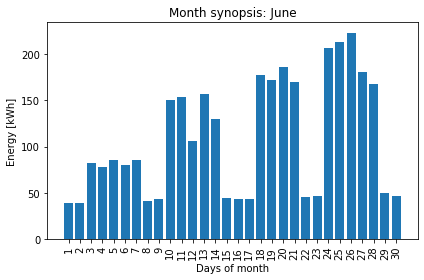

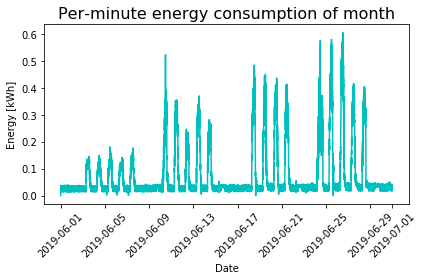

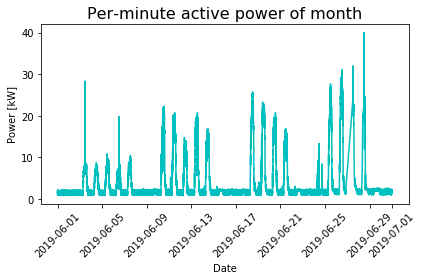

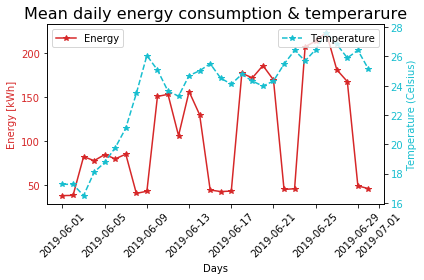

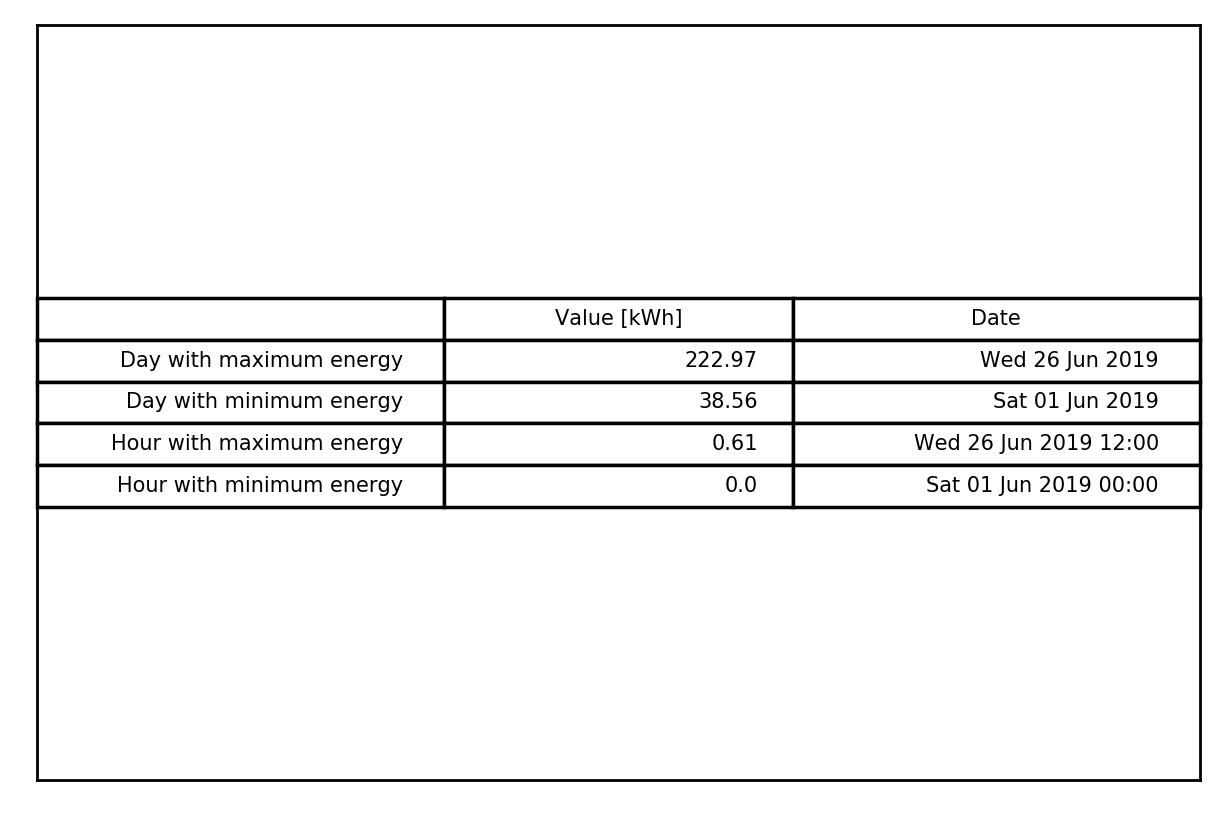

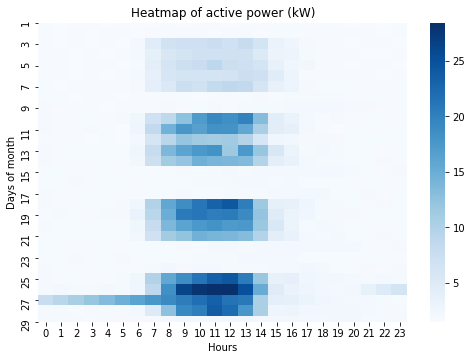

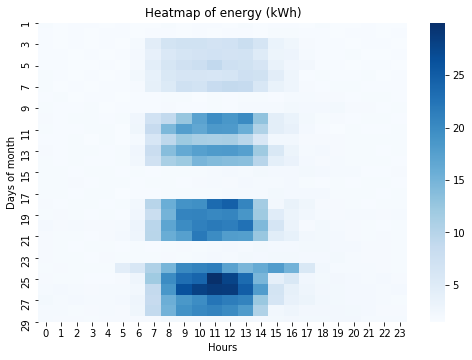

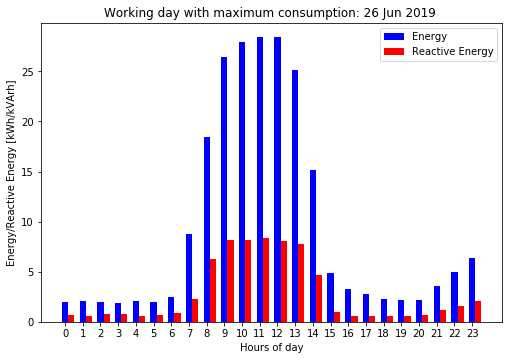

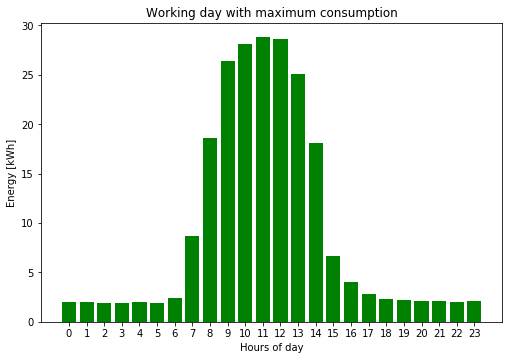

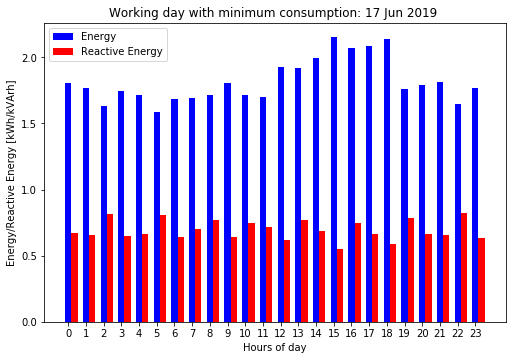

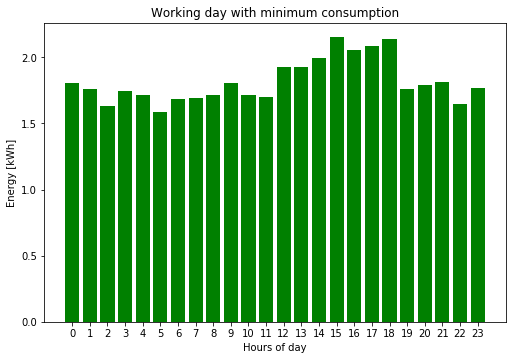

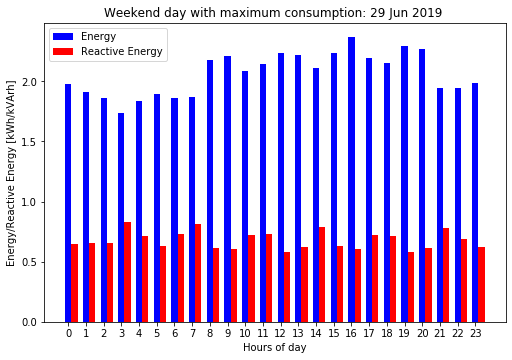

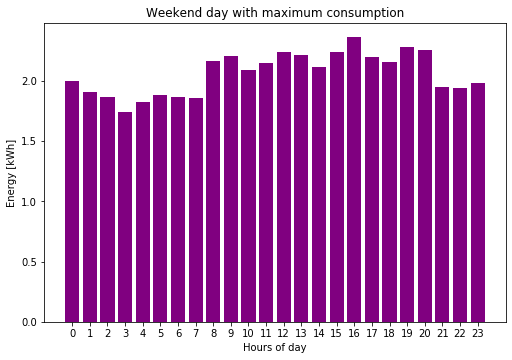

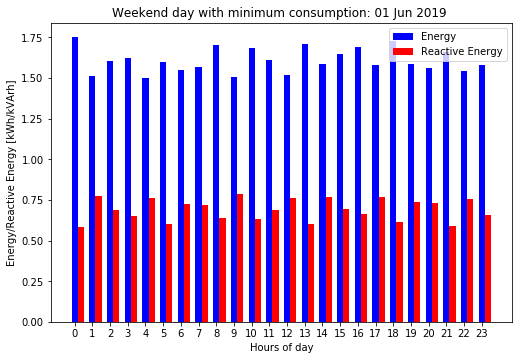

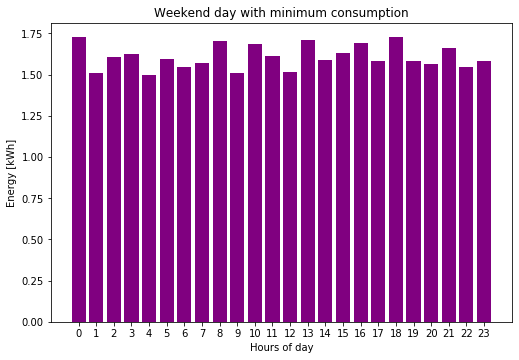

In [166]:
# #download, merge and add labels to data
startm = ['1559336400000','1561928400000','1564606800000','1567285200000']
endm = ['1561928399000','1564606799000','1567285199000','1569877199000']



Month = ['June','July','August','September']



path = "PDE_Results"
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

# for i in range(19, devices.shape[0]):
for i in range(0, 1):

    
    path = "PDE_Results/" + devices.name[i] + str(i)

    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)
        
    for j in range(0,1):
        
        path = "PDE_Results/" + devices.name[i] + str(i) + '/' + str(Month[j])
        print(path)

        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Successfully created the directory %s " % path)
            
        print(str(devices.id[i]))
        energy = get_energy_data(startm[j], endm[j], str(devices.id[i]))
        
        if energy.empty==False:
            energy = energy.reset_index(drop = False)
            energy.columns = ['Timestamp', 'totalnrg','nrgA', 'nrgB', 'nrgC']
            power = download_data(startm[j], endm[j], str(devices.id[i]), str(devices.asset[i]))
            df = pd.merge(power, energy, how='inner', on='Timestamp')
            df = set_labels(df)
            try :
                plot_energy_for_each_day(df, path)
            except :
                print('fail')
            try :
                plot_energy_for_the_whole_month(df, path)
            except :
                print('fail')
            try :
                plot_power_for_the_whole_month(df, path)
            except :
                print('fail')
            try:
                plot_energy_and_temperature(df, path)
            except :
                print('fail')
            try :
                plot_month_statistics(df, path)
            except :
                print('fail')
            try: 
                heatmap_with_power(df, path)
            except :
                print('fail')
            try :
                heatmap_with_energy(df, path)
            except :
                print('fail')

            try :
                power_of_working_day_with_maximum_consumption(df, path)
            except :
                print('fail')
            try :
                energy_of_working_day_with_maximum_consumption(df, path)
            except :
                print('fail')

            try :
                power_of_working_day_with_minimum_consumption(df, path)
            except :
                print('fail')
            try :
                energy_of_working_day_with_minimum_consumption(df, path)
            except :
                print('fail')

            try :
                power_of_weekend_with_maximum_consumption(df, path)
            except :
                print('fail')
            try :
                energy_of_weekend_with_maximum_consumption(df, path)
            except :
                print('fail')

            try :
                power_of_weekend_with_minimum_consumption(df, path)
            except :
                print('fail')
            try :
                energy_of_weekend_with_minimum_consumption(df, path)
            except :
                print('fail')
